<a href="https://colab.research.google.com/github/RaghavendraGaleppa/FaceRecognitionAssignment/blob/master/Face_Recogition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FACE REOGNITION ASSIGNMENT



### GDRIVE SETUP
- First Mount your drive, unzip the dataset and print total number of images


In [1]:
from google.colab import drive
drive.mount('/gdrive')
!cd /gdrive

Mounted at /gdrive


In [2]:
!unzip -o -qq /gdrive/'My Drive'/Dumpster/trainset.zip -d data/ 

In [3]:
import glob
all_files = glob.glob('data/*/*/*/*')
all_faces = glob.glob('data/**/**/**')
print(len(all_files)), print(len(all_faces))

4419
1012


(None, None)

### IMPORTS 

In [4]:
""" Pytorch functions """
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

""" Dlib """
import dlib

""" General libraries """
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

""" System Libraries """
import os
import collections
from datetime import datetime

""" Facenet """
!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1

""" Imgaug """
!pip uninstall -y imgaug && pip install git+https://github.com/aleju/imgaug.git
import imgaug as ia
import imgaug.augmenters as iaa

     |████████████████████████████████| 1.9MB 2.7MB/s 
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-oo836vbr
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-oo836vbr
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=89ed29c1dd60d830486770349af60100f3316cb51467b731fe4459175bb088dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-wh0ikmug/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


#### Constants

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128
PIN_MEM = True if device == 'cuda' else False
NUM_WOR = 8 if PIN_MEM else 1

GDRIVE='/gdrive'
MODEL_SAVE_PATH = os.path.join('/gdrive/My Drive/FaceRecogModels')
if not os.path.isdir(MODEL_SAVE_PATH):
    print(f"Creating the model saving directory {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"Model saving directory {MODEL_SAVE_PATH} already exists")


Model saving directory /gdrive/My Drive/FaceRecogModels already exists


### FACE DETECTION AND ALIGNMENT
- Using FACENET PACKAGE IN PRACTICE!
- The very first step in the face recognition pipeline will be to create a bounding box of the face, crop that area, scale it and align it so that nose of the face is at the center of the image.
- To do this we will use the dlib library, which contains pretrained face detector and landmarks detector.


In [6]:
""" The landmarks.dat file, is a pretrained network, designed to detect landmarks on the face """
!wget 'https://github.com/AKSHAYUBHAT/TensorFace/blob/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat?raw=true' -O 'landmarks.dat'

--2020-09-21 13:09:34--  https://github.com/AKSHAYUBHAT/TensorFace/blob/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AKSHAYUBHAT/TensorFace/raw/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat [following]
--2020-09-21 13:09:35--  https://github.com/AKSHAYUBHAT/TensorFace/raw/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AKSHAYUBHAT/TensorFace/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat [following]
--2020-09-21 13:09:35--  https://raw.githubusercontent.com/AKSHAYUBHAT/TensorFace/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat
Resolving raw.githubus

In [7]:
def rect_to_bb(rects):
    """
        - The dlib outputs the bounding box of face in terms of (left,top) and (rigth,bottom) 
        coordinates. This function converts it to (x, y, width, height), so that we can plot 
        it in matplotlib.
    """
    new_rects = []
    for rect in rects:
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y

        new_rects.append([x,y,w,h])
    return new_rects

def plot_image_with_bb(image, bbs):
    """
        Plots the image with the bounding boxes
        - image: numpy array of shape like (width,height,channels)
        - bbs: a list of lists. Each list inside bbs, is a list [x,y,height,width], which represents
        the bounding box in the image.
    """

    fig,ax = plt.subplots(1,1,figsize=(8,8))

    for bb in bbs:
        rect = Rectangle((bb[0],bb[1]),
                         bb[2], bb[3],
                         lw=2,
                         color='blue',
                         fill=False)
        ax.add_patch(rect)

    ax.imshow(image)
    plt.show()
        

 The new bounding boxes are: [[81, 110, 129, 129]]


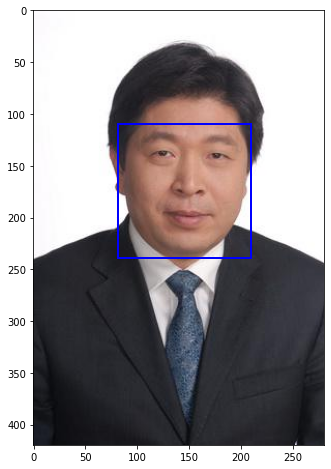

In [8]:
FACE_LANDMARKS_PATH = 'landmarks.dat'
image = cv2.imread(all_files[200])

face_detector = dlib.get_frontal_face_detector() # A pretrained face detector, that can predict bounding boxes for faces 

shape_predictor = dlib.shape_predictor(FACE_LANDMARKS_PATH)  # A pretrained face landmark detector
required_landmarks = dlib.full_object_detections() # Get the 5 landmarks that are needed for face alignment

faces = face_detector(image,1) # Detect faces

new_bbs = rect_to_bb(faces) # Modify the bounding boxes
print(f" The new bounding boxes are: {new_bbs}")

plot_image_with_bb(image[...,::-1],new_bbs) # Plot the image with the face bounding box

In [9]:
for det in faces:
    required_landmarks.append(shape_predictor(image,det))
    
chipped_faces = dlib.get_face_chips(image, required_landmarks, size=160) # crop and align the face


(160, 160, 3)


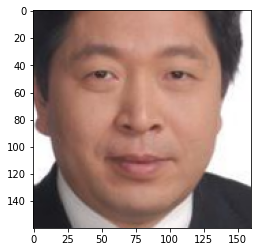

In [10]:
plt.imshow(chipped_faces[0][...,::-1])
print(chipped_faces[0].shape)
cropped_img = chipped_faces[0][...,::-1][np.newaxis,...]

### DATA AUGMENTATION

#### FlipLR - Horizontal Flip

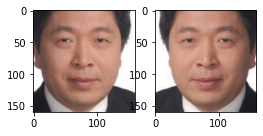

In [11]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
img = iaa.Fliplr(1.0)(images=cropped_img)
ax[0].imshow(chipped_faces[0][...,::-1])
ax[1].imshow(img.squeeze(0))

#### Motion Blur

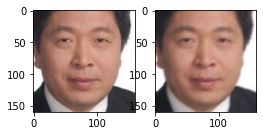

In [12]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
img = iaa.MotionBlur(k=5)(images=cropped_img)
ax[0].imshow(chipped_faces[0][...,::-1])
ax[1].imshow(img.squeeze(0))

#### Cutout

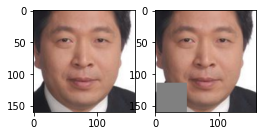

In [13]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
aug = iaa.Cutout(nb_iterations=1, size=0.3)
img = aug(images=cropped_img)
ax[0].imshow(cropped_img.squeeze(0))
ax[1].imshow(img.squeeze(0))

#### Brightness

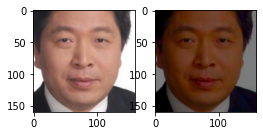

In [14]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
aug = iaa.MultiplyAndAddToBrightness(mul=(0.5,1.5),add=(-30,30))
img = aug(images=cropped_img)
ax[0].imshow(cropped_img.squeeze(0))
ax[1].imshow(img.squeeze(0))

#### Combining all augmentations

In [15]:
class FaceAugmentation(object):

    def __init__(self):
        self.sometimes = lambda aug: iaa.Sometimes(1/3, aug)
        self.fliplr = iaa.Fliplr(0.5)
        self.cutout = self.sometimes(iaa.Cutout(nb_iterations=1,size=0.25))
        self.blur = self.sometimes(iaa.MotionBlur(k=5))
        self.brightness = self.sometimes(iaa.MultiplyAndAddToBrightness(
                            mul=(0.2,2.0),add=(-40,40)
                        ))
        self.seq = iaa.Sequential([
            self.fliplr,
            self.cutout,
            self.blur,
            self.brightness,
        ])
    
    def __call__(self,x):
        x = x[np.newaxis,...]
        x = self.seq(images=x)
        x = x.squeeze()
        return x
        

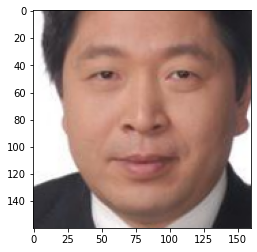

In [16]:
fa = FaceAugmentation()
plt.imshow(fa(cropped_img.squeeze()))

### DATASET PREPERATION
- Preparing the dataset is very essential. We have to be carefull about the kind of Augmentations, transformations we are going to use. 

- During the first stage of training. I am not going to use any augmentation. I will also triple the number of times the script images are loaded in a training epoch

- Load all the images, crop them, and then save them back on your drive.

#### Plotting faces for each folder in the dataset

In [17]:
def plot_faces(folder):
    folder_images = os.listdir(folder)
    nrows = len(folder_images)//4 + 1
    ncols = 4
    figsize=(ncols*4,nrows*4)

    fig,ax = plt.subplots(nrows,ncols,figsize=figsize)
    ax = ax.reshape(-1)
    for i,img_name in enumerate(folder_images):
        img = cv2.imread(os.path.join(folder,img_name))[...,::-1]
        ax[i].imshow(img)
        ax[i].set_title(img_name)
    plt.show()


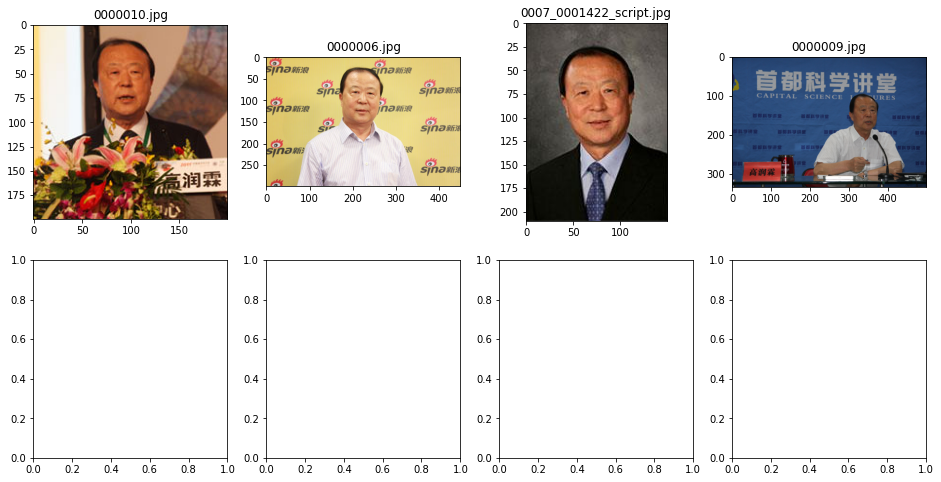

In [18]:
plot_faces(all_faces[30])

#### A function to center align faces

In [19]:
class CenterFaceAlign(object):

    def __init__(self, method="dlib"):
        """
            - method can be dlib or mtcnn
        """
        self.method = method.lower()
        if self.method == "mtcnn":
            self.mtcnn = MTCNN(device=device, post_process=False)
        elif self.method == "dlib":
            FACE_LANDMARKS_PATH = 'landmarks.dat'
            self.face_detector = dlib.get_frontal_face_detector()
            self.shape_predictor = dlib.shape_predictor(FACE_LANDMARKS_PATH) 


    def __call__(self,image,to_tensor=False):
        if self.method == "mtcnn":
            return self.mtcnn(image)
        else:
            faces = face_detector(image,1) 
            if len(faces) >= 1:
                required_landmarks = dlib.full_object_detections()
                required_landmarks.append(self.shape_predictor(image,faces[0]))
                chipped_face = dlib.get_face_chips(image, required_landmarks, size=160) 
                if to_tensor:
                    face_tensor = torch.from_numpy(chipped_face[0].transpose(2,0,1)/255).float()
                else:
                    face_tensor = chipped_face
            else:
                    face_tensor = False
            return face_tensor

#### Function to crop and center align images and then save them onto the disk

In [20]:
def save_all_cropped_faces(root_dir, new_root_dir):
    """ This function will take all the images, crop them and then 
    save them back onto the disk 
    """
    unique_faces = glob.glob(f'{root_dir}/**/**/**')
    all_images = glob.glob(f"{root_dir}/**/**/**/**")
    center_align = CenterFaceAlign(method='mtcnn')

    print(f"Creating new dirs")
    for f in tqdm(unique_faces):
        new_path = f.replace(root_dir,new_root_dir)
        os.makedirs(new_path)

    print(f"Creating Cropped Images and Saving them")
    for img_file in tqdm(all_images):
        img = cv2.imread(img_file)
        cropped_img = center_align(img)
        if isinstance(cropped_img, torch.Tensor):
            cropped_img = cropped_img.cpu().squeeze().numpy().transpose(1,2,0)
            new_img_file = img_file.replace(root_dir, new_root_dir)
            cv2.imwrite(new_img_file, cropped_img)

In [21]:
if not os.path.isdir('new_data'):
    save_all_cropped_faces('data','new_data')

  0%|          | 0/4419 [00:00<?, ?it/s]

Creating new dirs
Creating Cropped Images and Saving them


100%|██████████| 4419/4419 [05:03<00:00, 14.54it/s]


#### Face Recognition dataset class

In [22]:
def get_images_in_a_folder(folder):
    """ Get all the images in the folder, in their full path """
    images = os.listdir(folder)
    full_paths = []
    for i in images:
        full_paths.append(os.path.join(folder,i))

    return full_paths

In [23]:
class FaceRecognitionDataset(Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.unique_faces = glob.glob(os.path.join(root_dir,'**/**/**'))
        self.all_train_faces, self.test_faces = train_test_split(self.unique_faces, 
                                                             train_size=0.95,
                                                             shuffle=True,
                                                             random_state=42)
        print(f"Dataset split into {len(self.all_train_faces)} train faces, {len(self.test_faces)} test faces")
        self.all_train_labels = {j.split('/')[-1]:i for i, j in enumerate(self.all_train_faces)}
        self.num_classes = len(self.all_train_faces)

         
        self.all_train_images = list(map(get_images_in_a_folder, self.all_train_faces))
        self.all_train_images = [img_file for sub in self.all_train_images for img_file in sub]

        self.test_images = list(map(get_images_in_a_folder,self.test_faces))
        self.test_images = [img_file for sub in self.test_images for img_file in sub]
        
        print(f"Total of {len(self.all_train_images)} images in train")
        print(f"Total of {len(self.test_images)} images in test")

        basic_set = collections.namedtuple('TrainSet', ['normal','script'])
        normal_images = [i for i in self.all_train_images if 'script' not in i]
        script_images = [i for i in self.all_train_images if 'script' in i]
        print(f"Found {len(normal_images)} normal and {len(script_images)} script in train images")

        self.all_train_set = basic_set(normal_images, script_images)

        self.modified_train_set = []
        self.modified_train_set.extend(self.all_train_set.normal)
        self.modified_train_set.extend(self.all_train_set.script*3)
        print(f"Created modified train set of length: {len(self.modified_train_set)}")
        print(f"New normal_images: {len(self.all_train_set.normal)}")
        print(f"New script_images: {len(self.all_train_set.script * 3)}")

        self.training_set, self.val_set = train_test_split(self.modified_train_set,
                                                           train_size=0.8,
                                                           shuffle=True,
                                                           random_state=42)

        print(f"Created the training set: {len(self.training_set)}")
        print(f"Created the val set: {len(self.val_set)}")

        self.mode = 'train'
        self.crop_image_transform = CenterFaceAlign()
        self.normalize = transforms.Normalize( [ 0.485, 0.456, 0.406 ],
                                                 [ 0.229, 0.224, 0.225 ])
        self.face_augmentation = FaceAugmentation()                                                 

    def __len__(self):
        if self.mode == 'train':
            return len(self.training_set)
        elif self.mode == 'val':
            return len(self.val_set)
    
    def __getitem__(self,idx,transform_image=False):
        if self.mode == 'train':
            img_file = self.training_set[idx]
        elif self.mode == 'val':
            img_file = self.val_set[idx]
        else:
            raise ValueError("Error mode can be either 'training' or 'val'")

        img = cv2.imread(img_file)[...,::-1]
        if self.mode == 'train':
            img = self.face_augmentation(img)
        img = img.transpose(2,0,1)
        #cropped_image = img.copy().transpose(2,0,1)
        cropped_image_tensor = torch.from_numpy(img.copy()).float()/255.0
        cropped_image_tensor = self.normalize(cropped_image_tensor)
        label = self.all_train_labels[img_file.split('/')[-2]]
        label = torch.tensor(label).long()
        return cropped_image_tensor, label

#### Face Recognition Dataset Dataloader

In [24]:
face_dataset =  FaceRecognitionDataset('new_data')
face_dataloader = DataLoader(face_dataset, batch_size = BATCH_SIZE, shuffle=True,
                             pin_memory = False, 
                             #num_workers = 8
                            )

Dataset split into 961 train faces, 51 test faces
Total of 3964 images in train
Total of 204 images in test
Found 2822 normal and 1142 script in train images
Created modified train set of length: 6248
New normal_images: 2822
New script_images: 3426
Created the training set: 4998
Created the val set: 1250


In [25]:
face_dataset.mode = 'train'
print(len(face_dataloader))

face_dataset.mode = 'val'
print(len(face_dataloader))

40
10


In [26]:
%timeit next(iter(face_dataloader))
img, labels = next(iter(face_dataloader))
print(img.size())

1 loop, best of 3: 195 ms per loop
torch.Size([128, 3, 160, 160])


### TRAINING

#### Saving model at checkpoint function

In [27]:
def save_model(model, epoch, train_loss, val_loss, val_acc):
    model_state_dict = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_acc': val_acc,
    }
    now = datetime.now()
    save_path = datetime.strftime(now, f"%y%m%d%H%M%S_{val_loss:.2f}_{val_acc:.2f}")
    save_path = os.path.join(MODEL_SAVE_PATH,save_path)
    torch.save(model_state_dict,save_path)


#### Initializing model, optimizer, loss function and other constants

In [28]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True


In [29]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=True,
                           num_classes=face_dataset.num_classes)

freeze_model(resnet)
resnet.logits = nn.Linear(resnet.last_linear.out_features,face_dataset.num_classes)
resnet = resnet.to(device)
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.01,
                            momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()


#### Creating the training loop

In [30]:
def train(model, optimizer, criterion, epochs):
    for e in range(epochs):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
    
        face_dataset.mode = 'train'
        model.train()
        t = tqdm(face_dataloader)
        for img, labels in t:
            img, labels = img.to(device), labels.to(device)
    
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            _, pred = torch.max(out.data,1)
            acc = (pred == labels).sum().item()
            train_acc.append(acc/BATCH_SIZE)
            t.set_postfix(train_loss=f"{loss.item():.2f}",
                        train_acc=f"{acc/BATCH_SIZE:.5f}"
                        )
    
        print(f"\nE:{e+1}/{epochs}|TA:{np.mean(train_acc):.5f}, TL:{np.mean(train_loss):.2f}")
        face_dataset.mode = 'val'
        model.eval() 
        t = tqdm(face_dataloader)
        for img, labels in t:
            img, labels = img.to(device), labels.to(device)
            out = model(img)
            loss = criterion(out, labels) 
            val_loss.append(loss.item())
            _, pred = torch.max(out.data,1)
            acc = (pred == labels).sum().item()
            val_acc.append(acc/BATCH_SIZE)
            t.set_postfix(val_loss=f"{loss.item():.2f}",
                        val_acc=f"{acc/BATCH_SIZE:.5f}"
                        )
            pass
        print(f"\nE:{e+1}/{epochs}|VA:{np.mean(val_acc):.5f}, VL:{np.mean(val_loss):.2f}")
        if ((e+1)%5) == 0:
            save_model(model, e+1, np.mean(train_loss),
                    np.mean(val_loss),
                    np.mean(val_acc))

In [31]:
train(resnet, optimizer, criterion, 20)


  0%|          | 0/10 [00:00<?, ?it/s]


E:1/20|TA:0.01699, TL:6.69


  0%|          | 0/40 [00:00<?, ?it/s]


E:1/20|VA:0.07578, VL:6.15


  0%|          | 0/10 [00:00<?, ?it/s]


E:2/20|TA:0.18008, TL:5.57


  0%|          | 0/40 [00:00<?, ?it/s]


E:2/20|VA:0.23125, VL:5.18


  0%|          | 0/10 [00:00<?, ?it/s]


E:3/20|TA:0.32207, TL:4.57


  0%|          | 0/40 [00:00<?, ?it/s]


E:3/20|VA:0.33516, VL:4.38


  0%|          | 0/10 [00:00<?, ?it/s]


E:4/20|TA:0.45742, TL:3.77


  0%|          | 0/40 [00:00<?, ?it/s]


E:4/20|VA:0.25391, VL:4.84


  0%|          | 0/10 [00:00<?, ?it/s]


E:5/20|TA:0.57090, TL:3.13


100%|██████████| 10/10 [00:04<00:00,  2.14it/s, val_acc=0.35938, val_loss=3.30]



E:5/20|VA:0.52031, VL:3.29


  0%|          | 0/10 [00:00<?, ?it/s]


E:6/20|TA:0.64824, TL:2.71


  0%|          | 0/40 [00:00<?, ?it/s]


E:6/20|VA:0.59453, VL:2.84


  0%|          | 0/10 [00:00<?, ?it/s]


E:7/20|TA:0.71445, TL:2.33


  0%|          | 0/40 [00:00<?, ?it/s]


E:7/20|VA:0.65625, VL:2.50


  0%|          | 0/10 [00:00<?, ?it/s]


E:8/20|TA:0.76055, TL:1.97


  0%|          | 0/40 [00:00<?, ?it/s]


E:8/20|VA:0.69922, VL:2.20


  0%|          | 0/10 [00:00<?, ?it/s]


E:9/20|TA:0.78223, TL:1.81


  0%|          | 0/40 [00:00<?, ?it/s]


E:9/20|VA:0.71250, VL:2.05


  0%|          | 0/10 [00:00<?, ?it/s]


E:10/20|TA:0.80977, TL:1.60


100%|██████████| 10/10 [00:04<00:00,  2.13it/s, val_acc=0.64844, val_loss=1.56]



E:10/20|VA:0.74687, VL:1.79


  0%|          | 0/10 [00:00<?, ?it/s]


E:11/20|TA:0.82344, TL:1.48


  0%|          | 0/40 [00:00<?, ?it/s]


E:11/20|VA:0.76797, VL:1.65


  0%|          | 0/10 [00:00<?, ?it/s]


E:12/20|TA:0.83340, TL:1.40


  0%|          | 0/40 [00:00<?, ?it/s]


E:12/20|VA:0.77266, VL:1.61


  0%|          | 0/10 [00:00<?, ?it/s]


E:13/20|TA:0.84316, TL:1.29


  0%|          | 0/40 [00:00<?, ?it/s]


E:13/20|VA:0.78359, VL:1.45


  0%|          | 0/10 [00:00<?, ?it/s]


E:14/20|TA:0.85547, TL:1.22


  0%|          | 0/40 [00:00<?, ?it/s]


E:14/20|VA:0.80391, VL:1.30


  0%|          | 0/10 [00:00<?, ?it/s]


E:15/20|TA:0.85371, TL:1.10


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, val_acc=0.68750, val_loss=1.07]



E:15/20|VA:0.81094, VL:1.28


  0%|          | 0/10 [00:00<?, ?it/s]


E:16/20|TA:0.86504, TL:1.04


  0%|          | 0/40 [00:00<?, ?it/s]


E:16/20|VA:0.82109, VL:1.12


  0%|          | 0/10 [00:00<?, ?it/s]


E:17/20|TA:0.86543, TL:1.00


  0%|          | 0/40 [00:00<?, ?it/s]


E:17/20|VA:0.83437, VL:1.06


  0%|          | 0/10 [00:00<?, ?it/s]


E:18/20|TA:0.86387, TL:0.98


  0%|          | 0/40 [00:00<?, ?it/s]


E:18/20|VA:0.83828, VL:1.04


  0%|          | 0/10 [00:00<?, ?it/s]


E:19/20|TA:0.86621, TL:0.96


  0%|          | 0/40 [00:00<?, ?it/s]


E:19/20|VA:0.80781, VL:1.16


  0%|          | 0/10 [00:00<?, ?it/s]


E:20/20|TA:0.87422, TL:0.87


100%|██████████| 10/10 [00:04<00:00,  2.07it/s, val_acc=0.69531, val_loss=0.90]



E:20/20|VA:0.85000, VL:0.96


In [32]:
resnet.last_linear.weight.requires_grad = True
train(resnet, optimizer, criterion, 20)

  0%|          | 0/10 [00:00<?, ?it/s]


E:1/20|TA:0.87285, TL:0.91


  0%|          | 0/40 [00:00<?, ?it/s]


E:1/20|VA:0.85000, VL:0.94


  0%|          | 0/10 [00:00<?, ?it/s]


E:2/20|TA:0.87168, TL:0.83


  0%|          | 0/40 [00:00<?, ?it/s]


E:2/20|VA:0.86094, VL:0.85


  0%|          | 0/10 [00:00<?, ?it/s]


E:3/20|TA:0.87676, TL:0.82


  0%|          | 0/40 [00:00<?, ?it/s]


E:3/20|VA:0.85859, VL:0.82


  0%|          | 0/10 [00:00<?, ?it/s]


E:4/20|TA:0.87813, TL:0.77


  0%|          | 0/40 [00:00<?, ?it/s]


E:4/20|VA:0.86953, VL:0.79


  0%|          | 0/10 [00:00<?, ?it/s]


E:5/20|TA:0.88848, TL:0.73


100%|██████████| 10/10 [00:04<00:00,  2.06it/s, val_acc=0.72656, val_loss=0.57]



E:5/20|VA:0.86953, VL:0.78


  0%|          | 0/10 [00:00<?, ?it/s]


E:6/20|TA:0.87871, TL:0.76


  0%|          | 0/40 [00:00<?, ?it/s]


E:6/20|VA:0.87422, VL:0.74


  0%|          | 0/10 [00:00<?, ?it/s]


E:7/20|TA:0.88262, TL:0.73


  0%|          | 0/40 [00:00<?, ?it/s]


E:7/20|VA:0.87500, VL:0.74


  0%|          | 0/10 [00:00<?, ?it/s]


E:8/20|TA:0.88691, TL:0.70


  0%|          | 0/40 [00:00<?, ?it/s]


E:8/20|VA:0.87266, VL:0.72


  0%|          | 0/10 [00:00<?, ?it/s]


E:9/20|TA:0.88945, TL:0.67


  0%|          | 0/40 [00:00<?, ?it/s]


E:9/20|VA:0.87969, VL:0.68


  0%|          | 0/10 [00:00<?, ?it/s]


E:10/20|TA:0.88555, TL:0.70


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, val_acc=0.67188, val_loss=0.66]



E:10/20|VA:0.87734, VL:0.72


  0%|          | 0/10 [00:00<?, ?it/s]


E:11/20|TA:0.89277, TL:0.67


  0%|          | 0/40 [00:00<?, ?it/s]


E:11/20|VA:0.87422, VL:0.73


  0%|          | 0/10 [00:00<?, ?it/s]


E:12/20|TA:0.88828, TL:0.69


  0%|          | 0/40 [00:00<?, ?it/s]


E:12/20|VA:0.87500, VL:0.69


  0%|          | 0/10 [00:00<?, ?it/s]


E:13/20|TA:0.89551, TL:0.61


  0%|          | 0/40 [00:00<?, ?it/s]


E:13/20|VA:0.87500, VL:0.66


  0%|          | 0/10 [00:00<?, ?it/s]


E:14/20|TA:0.89238, TL:0.63


  0%|          | 0/40 [00:00<?, ?it/s]


E:14/20|VA:0.87344, VL:0.66


  0%|          | 0/10 [00:00<?, ?it/s]


E:15/20|TA:0.89355, TL:0.63


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, val_acc=0.68750, val_loss=0.55]



E:15/20|VA:0.88047, VL:0.62


  0%|          | 0/10 [00:00<?, ?it/s]


E:16/20|TA:0.89277, TL:0.61


  0%|          | 0/40 [00:00<?, ?it/s]


E:16/20|VA:0.87422, VL:0.64


  0%|          | 0/10 [00:00<?, ?it/s]


E:17/20|TA:0.89121, TL:0.63


  0%|          | 0/40 [00:00<?, ?it/s]


E:17/20|VA:0.87891, VL:0.65


  0%|          | 0/10 [00:00<?, ?it/s]


E:18/20|TA:0.89434, TL:0.58


  0%|          | 0/40 [00:00<?, ?it/s]


E:18/20|VA:0.88047, VL:0.63


  0%|          | 0/10 [00:00<?, ?it/s]


E:19/20|TA:0.90059, TL:0.57


  0%|          | 0/40 [00:00<?, ?it/s]


E:19/20|VA:0.87656, VL:0.64


  0%|          | 0/10 [00:00<?, ?it/s]


E:20/20|TA:0.89766, TL:0.60


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, val_acc=0.68750, val_loss=0.55]



E:20/20|VA:0.87656, VL:0.62


### FACE VERIFICATION

Looking at the embedding scores, we can safely say that using the number 0.8 as a cuttoff for similarity is best.

#### Intra Class Variation, distance Scores
Calculating the euclidean distance between images of the same person


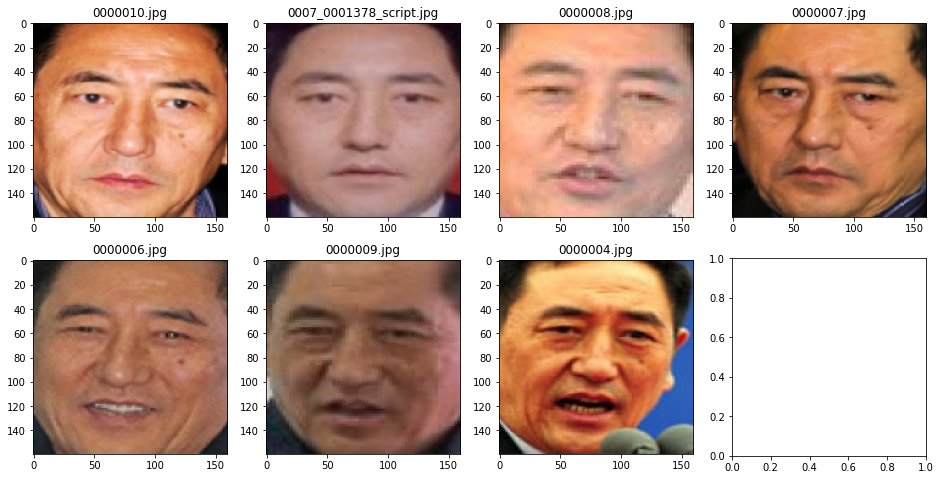

In [44]:
test_images = face_dataset.test_faces
plot_faces(test_images[35])

In [40]:
folder = test_images[35]
normal_images = [os.path.join(folder,i) for i in os.listdir(folder) if 'script' not in i]
script_images = [os.path.join(folder,i) for i in os.listdir(folder) if 'script' in i]

resnet.eval()
resnet.classify = False # to get embeddings
for s in script_images:
    s_img = cv2.imread(s)[...,::-1]/255.0
    s_img = s_img.transpose(2,0,1)
    s_img = torch.from_numpy(s_img)
    s_img = face_dataset.normalize(s_img).unsqueeze(0).float()
    s_img = s_img.to(device)
    s_embeddings = resnet(s_img)
    for n in normal_images:
        n_img = cv2.imread(n)[...,::-1]/255.0
        n_img = n_img.transpose(2,0,1)
        n_img = torch.from_numpy(n_img)
        n_img = face_dataset.normalize(n_img).unsqueeze(0).float()
        n_img = n_img.to(device)
        n_embeddings = resnet(n_img)

        score = (s_embeddings - n_embeddings).norm()
        print(f"Embedding score: {score}") 


Embedding score: 0.7768850922584534
Embedding score: 0.5967496037483215
Embedding score: 0.6813928484916687
Embedding score: 0.7061044573783875
Embedding score: 0.7345676422119141
Embedding score: 0.656269371509552


#### Inter Class Variation, distance Scores
Calculating the euclidean distances between images of different people

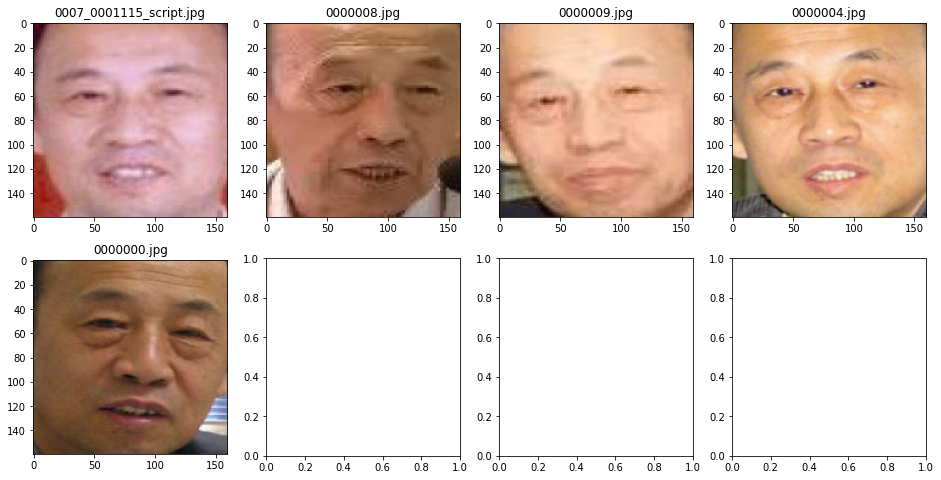

In [41]:
folder_1 = test_images[30]
plot_faces(folder_1)

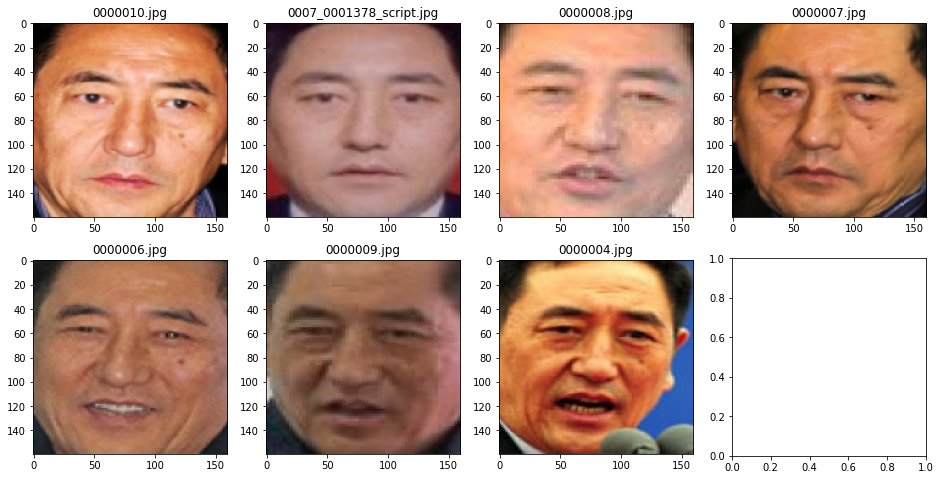

In [42]:
folder_2 = test_images[35]
plot_faces(folder_2)

In [43]:
normal_images = [os.path.join(folder_2,i) for i in os.listdir(folder_2) if 'script' not in i]
script_images = [os.path.join(folder_1,i) for i in os.listdir(folder_1) if 'script' in i]
print(script_images)
resnet.eval()
resnet.classify = False # to get embeddings
for s in script_images:
    print(s)
    s_img = cv2.imread(s)[...,::-1]/255.0
    s_img = s_img.transpose(2,0,1)
    s_img = torch.from_numpy(s_img)
    s_img = face_dataset.normalize(s_img).unsqueeze(0).float()
    s_img = s_img.to(device)
    s_embeddings = resnet(s_img)
    for n in normal_images:
        n_img = cv2.imread(n)[...,::-1]/255.0
        n_img = n_img.transpose(2,0,1)
        n_img = torch.from_numpy(n_img)
        n_img = face_dataset.normalize(n_img).unsqueeze(0).float()
        n_img = n_img.to(device)
        n_embeddings = resnet(n_img)

        score = (s_embeddings - n_embeddings).norm()
        print(f"Embedding score: {score}") 

['new_data/trainset/0007/0007_0001115/0007_0001115_script.jpg']
new_data/trainset/0007/0007_0001115/0007_0001115_script.jpg
Embedding score: 1.0442368984222412
Embedding score: 1.2217369079589844
Embedding score: 1.2441538572311401
Embedding score: 1.1914936304092407
Embedding score: 1.2129541635513306
Embedding score: 1.2029778957366943
